In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Load Data

### Playbyplay Dataset

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
figsize = (12, 8)

# Load the data
df_plays = pd.read_csv('playbyplaydataraw.csv')

# Quick statistics
print("Dataset Info:")
print("-" * 50)
print(f"Rows: {len(df_plays)}")
print(f"Columns: {len(df_plays.columns)}")
print(f"Memory usage: {df_plays.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Names:")
print(df_plays.columns.tolist())

print("\nData Types:")
print(df_plays.dtypes)

print("\nBasic Statistics:")
print(df_plays.describe())

Dataset Info:
--------------------------------------------------
Rows: 1697676
Columns: 25
Memory usage: 1108.62 MB

Column Names:
['gameId', 'actionNumber', 'clock', 'period', 'teamId', 'teamTricode', 'personId', 'playerName', 'playerNameI', 'xLegacy', 'yLegacy', 'shotDistance', 'shotResult', 'isFieldGoal', 'scoreHome', 'scoreAway', 'pointsTotal', 'location', 'description', 'actionType', 'subType', 'videoAvailable', 'shotValue', 'actionId', 'SEASON']

Data Types:
gameId              int64
actionNumber        int64
clock                 str
period              int64
teamId              int64
teamTricode           str
personId            int64
playerName            str
playerNameI           str
xLegacy             int64
yLegacy             int64
shotDistance        int64
shotResult            str
isFieldGoal         int64
scoreHome         float64
scoreAway         float64
pointsTotal         int64
location              str
description           str
actionType            str
subType    

In [3]:
print("Unique games:", df_plays['gameId'].nunique())
teams_per_game = df_plays.groupby('gameId')['teamId'].nunique()
print(teams_per_game.value_counts())
print(df_plays['period'].value_counts().sort_index())

Unique games: 3463
teamId
3    3463
Name: count, dtype: int64
period
1    409510
2    428456
3    417422
4    430954
5     10234
6      1100
Name: count, dtype: int64


### Game_ids

#### team_map

In [4]:
df_team = pd.read_csv("game_id.csv")
team_map = (
    df_team[['TEAM_ABBREVIATION', 'TEAM_ID']]
    .drop_duplicates()
    .sort_values('TEAM_ABBREVIATION')
    .reset_index(drop=True)
)

team_map

,TEAM_ABBREVIATION,TEAM_ID
0,ATL,1610612737
1,BKN,1610612751
2,BOS,1610612738
3,CHA,1610612766
4,CHI,1610612741
5,CLE,1610612739
6,DAL,1610612742
7,DEN,1610612743
8,DET,1610612765
9,GSW,1610612744


#### game_map

In [5]:
import re

df_games = pd.read_csv("game_id.csv")

m = df_games[['GAME_ID', 'MATCHUP']].drop_duplicates().copy()

# Normalize all whitespace (tabs, multiple spaces, NBSP) to single spaces
m['MATCHUP'] = (
    m['MATCHUP']
    .astype(str)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# Extract teams with one regex that handles both "@"" and "vs." (case-insensitive)
parsed = m['MATCHUP'].str.extract(
    r'^(?P<t1>[A-Z]{2,4})\s*(?P<sep>@|vs\.?)\s*(?P<t2>[A-Z]{2,4})$',
    flags=re.IGNORECASE
)

m = pd.concat([m, parsed], axis=1)

# Assign home/away depending on separator
m['away_team'] = m['t1'].where(m['sep'].str.lower() == '@', m['t2'])
m['home_team'] = m['t2'].where(m['sep'].str.lower() == '@', m['t1'])

game_map = (
    m.rename(columns={'GAME_ID': 'gameId'})[['gameId', 'home_team', 'away_team', 'MATCHUP']]
    .sort_values('gameId')
    .reset_index(drop=True)
)

game_map = game_map.merge(team_map, left_on='home_team', right_on='TEAM_ABBREVIATION') \
                   .rename(columns={'TEAM_ID':'home_team_id'}) \
                   .drop(columns=['TEAM_ABBREVIATION'])

game_map = game_map.merge(team_map, left_on='away_team', right_on='TEAM_ABBREVIATION') \
                   .rename(columns={'TEAM_ID':'away_team_id'}) \
                   .drop(columns=['TEAM_ABBREVIATION'])
game_map

,gameId,home_team,away_team,MATCHUP,home_team_id,away_team_id
0,22200001,BOS,PHI,BOS vs. PHI,1610612738,1610612755
1,22200002,GSW,LAL,GSW vs. LAL,1610612744,1610612747
2,22200003,DET,ORL,DET vs. ORL,1610612765,1610612753
3,22200004,IND,WAS,IND vs. WAS,1610612754,1610612764
4,22200005,ATL,HOU,ATL vs. HOU,1610612737,1610612745
...,...,...,...,...,...,...
3685,22401226,LAC,UTA,UTA @ LAC,1610612746,1610612762
3686,22401227,ORL,NYK,NYK @ ORL,1610612753,1610612752
3687,22401228,GSW,DAL,GSW vs. DAL,1610612744,1610612742
3688,22401229,MIL,ATL,ATL @ MIL,1610612749,1610612737


In [6]:
game_teams = pd.concat([
    game_map[['gameId','home_team']].rename(columns={'home_team':'teamId'}).assign(is_home=1),
    game_map[['gameId','away_team']].rename(columns={'away_team':'teamId'}).assign(is_home=0)
], ignore_index=True)
game_teams

,gameId,teamId,is_home
0,22200001,BOS,1
1,22200002,GSW,1
2,22200003,DET,1
3,22200004,IND,1
4,22200005,ATL,1
...,...,...,...
7375,22401226,UTA,0
7376,22401227,NYK,0
7377,22401228,DAL,0
7378,22401229,ATL,0


### More Sanity Checks

In [7]:
#df_plays.head(10).T

In [8]:
print(df_plays[df_plays['isFieldGoal'] == 1]['shotResult'].value_counts())
print(df_plays['shotValue'].value_counts())
print(df_plays.groupby('shotValue')['pointsTotal'].mean())
print(df_plays['shotResult'].value_counts())

shotResult
Missed    324383
Made      290538
Name: count, dtype: int64
shotValue
0    1048972
2     400486
3     248218
Name: count, dtype: int64
shotValue
0    18.785042
2    57.308171
3    41.070619
Name: pointsTotal, dtype: float64
shotResult
Missed    324383
Made      290538
Name: count, dtype: int64


In [9]:
# Find rows where subType contains "free throw" 
free_throw_rows = df_plays[df_plays['subType'].str.contains('free throw', case=False, na=False)]

# Show a few examples
#free_throw_rows.head(20).T
df_range = df_plays[
    (df_plays['gameId'] == 22201218) &
    (df_plays['actionNumber'] >= 130) &
    (df_plays['actionNumber'] <= 140)
].sort_values('actionNumber')

#df_range.T

## Preprocessing
Remove the OT and double OT games based on having period 5 and 6 above, this will help reduce noise and its impact on our data

In [10]:
ot_games = df_plays[df_plays['period'] > 4]['gameId'].unique()
df_clean = df_plays[~df_plays['gameId'].isin(ot_games)]
print("Games after OT removal:", df_clean['gameId'].nunique())

Games after OT removal: 3279


### Get scores per quarter

In [11]:
def get_quarter_scores(df_clean: pd.DataFrame, game_map: pd.DataFrame) -> pd.DataFrame:
    """
    Build a (team, game) modeling table with per-quarter points (Q1–Q4) using
    end-of-period cumulative scores (scoreHome/scoreAway), then differencing.

    Assumes overtime games have already been removed from df_clean.

    Returns columns:
      gameId, teamId, is_home, Q1_pts, Q2_pts, Q3_pts, Q4_pts, final_pts, win
    """
    # End-of-period rows for regulation quarters
    df_ends = df_clean[df_clean["period"].between(1, 4) & (df_clean["subType"] == "end")].copy()

    # One row per game/period: last end marker
    q_end = (
        df_ends.sort_values(["gameId", "period", "actionNumber"])
               .groupby(["gameId", "period"])[["scoreHome", "scoreAway"]]
               .last()
               .reset_index()
    )

    # Cumulative scores at end of each quarter
    home_cum = q_end.pivot(index="gameId", columns="period", values="scoreHome")
    away_cum = q_end.pivot(index="gameId", columns="period", values="scoreAway")

    # Per-quarter points (diff of cumulative; Q1 is cumulative itself)
    home_q = home_cum.diff(axis=1)
    away_q = away_cum.diff(axis=1)
    home_q[1] = home_cum[1]
    away_q[1] = away_cum[1]

    home_q.columns = ["Q1_pts", "Q2_pts", "Q3_pts", "Q4_pts"]
    away_q.columns = ["Q1_pts", "Q2_pts", "Q3_pts", "Q4_pts"]

    # Attach team IDs
    home_df = (
        home_q.reset_index()
              .merge(game_map[["gameId", "home_team_id"]], on="gameId")
              .rename(columns={"home_team_id": "teamId"})
              .assign(is_home=1)
    )

    away_df = (
        away_q.reset_index()
              .merge(game_map[["gameId", "away_team_id"]], on="gameId")
              .rename(columns={"away_team_id": "teamId"})
              .assign(is_home=0)
    )

    df_preprocessed = pd.concat([home_df, away_df], ignore_index=True)

    # Final points + win label
    df_preprocessed["final_pts"] = df_preprocessed[["Q1_pts", "Q2_pts", "Q3_pts", "Q4_pts"]].sum(axis=1)
    df_preprocessed["win"] = df_preprocessed.groupby("gameId")["final_pts"].transform(lambda x: x == x.max()).astype(int)

    return df_preprocessed

df_preprocessed = get_quarter_scores(df_clean=df_clean, game_map=game_map)

In [12]:

display(df_preprocessed.head())
display(df_preprocessed.groupby('gameId').size().value_counts())
display(df_preprocessed.groupby('gameId')['win'].sum().value_counts())
display((df_preprocessed
 .groupby('gameId')
 .apply(lambda x: x['final_pts'].sum())
 .describe()))

display(df_preprocessed['is_home'].value_counts())

,gameId,Q1_pts,Q2_pts,Q3_pts,Q4_pts,teamId,is_home,final_pts,win
0,22200001,24.0,39.0,35.0,28.0,1610612738,1,126.0,1
1,22200002,25.0,34.0,32.0,32.0,1610612744,1,123.0,1
2,22200003,17.0,40.0,34.0,22.0,1610612765,1,113.0,1
3,22200004,25.0,27.0,25.0,30.0,1610612754,1,107.0,0
4,22200005,26.0,33.0,25.0,33.0,1610612737,1,117.0,1


2    3279
Name: count, dtype: int64

win
1    3279
Name: count, dtype: int64

count    3279.000000
mean      227.376944
std        19.069972
min       152.000000
25%       214.000000
50%       227.000000
75%       240.000000
max       309.000000
dtype: float64

is_home
1    3279
0    3279
Name: count, dtype: int64

## EDA

### Split model into time-aware train/test do EDA only on the train set

In [64]:
df_preprocessed.sort_values(by='gameId', ascending=True)
df_train = pd.concat([df_preprocessed[0:2236], df_preprocessed[3280:5515]])
df_test = pd.concat([df_preprocessed[2236:3280], df_preprocessed[5515:]])

### Basic team stats

In [65]:
df_eda = df_train.copy()
df_eda.groupby('win')[['Q1_pts','Q2_pts','Q3_pts','Q4_pts']].mean()

,Q1_pts,Q2_pts,Q3_pts,Q4_pts
win,,,,
0,27.060850,27.247875,27.320358,26.182550
1,30.500894,30.217800,30.383721,28.920394


In [78]:
df_eda.head()

,gameId,Q1_pts,Q2_pts,Q3_pts,Q4_pts,teamId,is_home,final_pts,win,Q2_delta,Q3_delta,Q4_delta
0,22200001,24.0,39.0,35.0,28.0,1610612738,1,126.0,1,15.0,-4.0,-7.0
1,22200002,25.0,34.0,32.0,32.0,1610612744,1,123.0,1,9.0,-2.0,0.0
2,22200003,17.0,40.0,34.0,22.0,1610612765,1,113.0,1,23.0,-6.0,-12.0
3,22200004,25.0,27.0,25.0,30.0,1610612754,1,107.0,0,2.0,-2.0,5.0
4,22200005,26.0,33.0,25.0,33.0,1610612737,1,117.0,1,7.0,-8.0,8.0


Shape: (4471, 12)

Win distribution:
win
1    0.500112
0    0.499888
Name: proportion, dtype: float64

Quarter scoring summary:


,Q1_pts,Q2_pts,Q3_pts,Q4_pts
count,4471.000000,4471.000000,4471.000000,4471.000000
mean,28.781257,28.733169,28.852382,27.551778
std,6.062133,5.943558,5.956753,5.965369
min,10.000000,10.000000,9.000000,9.000000
25%,25.000000,25.000000,25.000000,23.000000
50%,29.000000,29.000000,29.000000,27.000000
75%,33.000000,33.000000,33.000000,32.000000
max,55.000000,51.000000,51.000000,49.000000


,Q1_pts,Q2_pts,Q3_pts,Q4_pts
win,,,,
0,27.060850,27.247875,27.320358,26.182550
1,30.500894,30.217800,30.383721,28.920394


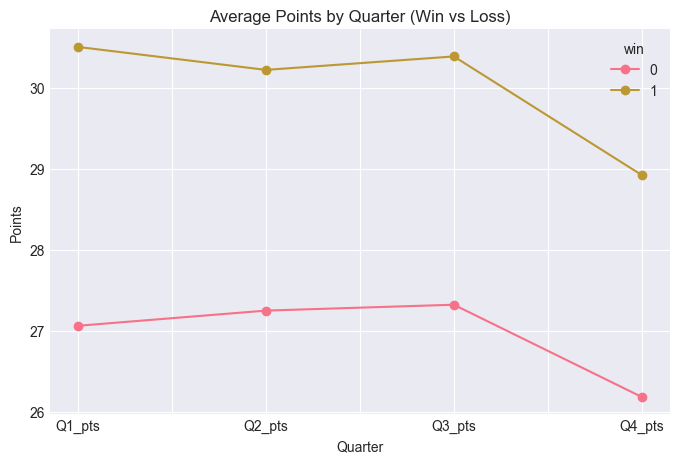

,Q2_delta,Q3_delta,Q4_delta
win,,,
0,0.187025,0.072483,-1.137808
1,-0.283095,0.165921,-1.463327


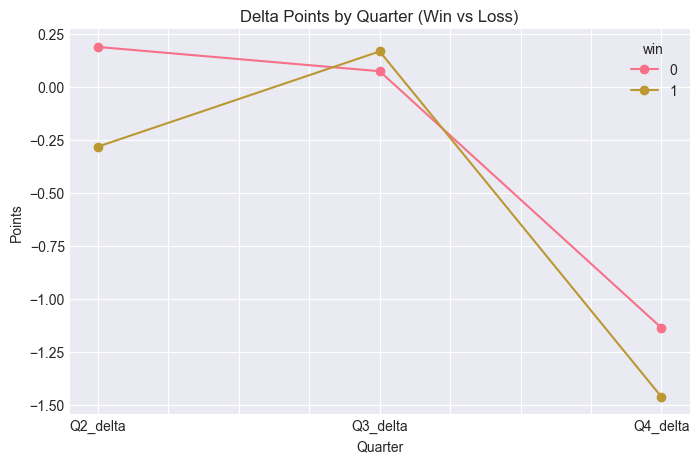

,Q1_diff,Q2_diff,Q3_diff,Q4_diff
win,,,,
0,-3.442953,-2.965996,-3.061298,-2.738255
1,3.442953,2.965996,3.061298,2.738255


win          1.000000
Q1_diff      0.394262
Q3_diff      0.362353
Q2_diff      0.356593
Q4_diff      0.347548
is_home_x    0.123937
Name: win, dtype: float64

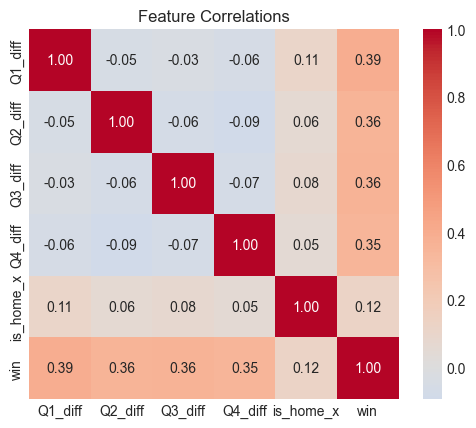

win            1.000000
cum_diff_Q3    0.675894
cum_diff_Q2    0.544858
cum_diff_Q1    0.394262
is_home_x      0.123937
Name: win, dtype: float64

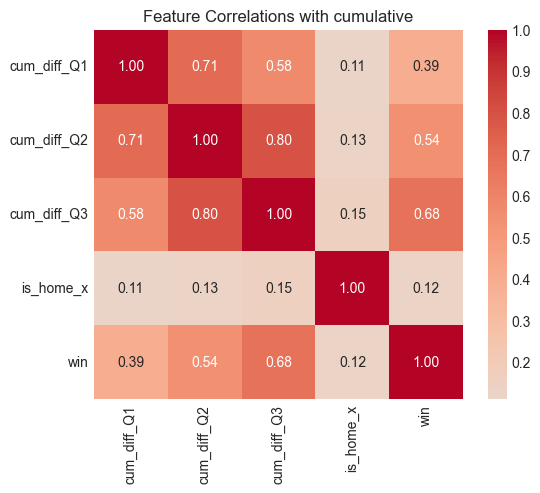

cum_diff_Q1    0.394262
cum_diff_Q2    0.544858
cum_diff_Q3    0.675894
win            1.000000
Name: win, dtype: float64

In [92]:
# Step 1 Basic Sanity checks
print("Shape:", df_eda.shape)
print("\nWin distribution:")
print(df_eda['win'].value_counts(normalize=True))

print("\nQuarter scoring summary:")
display(df_eda[['Q1_pts','Q2_pts','Q3_pts','Q4_pts']].describe())
# Step 2 Do Winners score more
quarter_means = df_eda.groupby('win')[['Q1_pts','Q2_pts','Q3_pts','Q4_pts']].mean()
display(quarter_means)

# 3. Quarter trends
quarter_means.T.plot(marker='o', figsize=(8,5))
plt.title("Average Points by Quarter (Win vs Loss)")
plt.ylabel("Points")
plt.xlabel("Quarter")
plt.show()

# 4. Quarter changes
df_eda['Q2_delta'] = df_eda['Q2_pts'] - df_eda['Q1_pts']
df_eda['Q3_delta'] = df_eda['Q3_pts'] - df_eda['Q2_pts']
df_eda['Q4_delta'] = df_eda['Q4_pts'] - df_eda['Q3_pts']

delta_means = df_eda.groupby('win')[['Q2_delta','Q3_delta','Q4_delta']].mean()
display(delta_means)

delta_means.T.plot(marker='o', figsize=(8,5))
plt.title("Delta Points by Quarter (Win vs Loss)")
plt.ylabel("Points")
plt.xlabel("Quarter")
plt.show()

# 5. Differentials
df_opp = df_eda.copy().rename(columns={
    'teamId':'opp_teamId',
    'Q1_pts':'opp_Q1_pts',
    'Q2_pts':'opp_Q2_pts',
    'Q3_pts':'opp_Q3_pts',
    'Q4_pts':'opp_Q4_pts',
    'final_pts':'opp_final_pts',
    'win':'opp_win'
})

df_full = df_eda.merge(df_opp, on='gameId')
df_full = df_full[df_full['teamId'] != df_full['opp_teamId']]

for q in ['Q1','Q2','Q3','Q4']:
    df_full[f'{q}_diff'] = df_full[f'{q}_pts'] - df_full[f'opp_{q}_pts']

diff_means = df_full.groupby('win')[['Q1_diff','Q2_diff','Q3_diff','Q4_diff']].mean()
display(diff_means)

# 6. Correlation with win, also create a momentum like parameter delta_diff
df_full['Q2_delta_diff'] = df_full['Q2_diff'] - df_full['Q1_diff']
df_full['Q3_delta_diff'] = df_full['Q3_diff'] - df_full['Q2_diff']
corr = df_full[['Q1_diff','Q2_diff','Q3_diff','Q4_diff', 'is_home_x', 'win']].corr()
display(corr['win'].sort_values(ascending=False))

# One with correlations
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True)
plt.title('Feature Correlations')
plt.show()

# 7 Running game state
df_full['cum_diff_Q1'] = df_full['Q1_diff']
df_full['cum_diff_Q2'] = df_full['Q1_diff'] + df_full['Q2_diff']
df_full['cum_diff_Q3'] = df_full['cum_diff_Q2'] + df_full['Q3_diff']

corr = df_full[['cum_diff_Q1','cum_diff_Q2','cum_diff_Q3','is_home_x', 'win']].corr()
display(corr['win'].sort_values(ascending=False))

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True)
plt.title('Feature Correlations with Cumulative Score Difference')
plt.show()


display(df_full[['cum_diff_Q1','cum_diff_Q2','cum_diff_Q3','win']].corr()['win'])

In [87]:
df_full

,gameId,Q1_pts,Q2_pts,Q3_pts,Q4_pts,teamId,is_home_x,final_pts,win,Q2_delta_x,...,opp_win,Q2_delta_y,Q3_delta_y,Q4_delta_y,Q1_diff,Q2_diff,Q3_diff,Q4_diff,Q2_delta_diff,Q3_delta_diff
2,22200002,25.0,34.0,32.0,32.0,1610612744,1,123.0,1,9.0,...,0,8.0,-11.0,19.0,3.0,4.0,13.0,-6.0,1.0,9.0
4,22200003,17.0,40.0,34.0,22.0,1610612765,1,113.0,1,23.0,...,0,-1.0,1.0,-2.0,-11.0,13.0,6.0,-4.0,24.0,-7.0
6,22200004,25.0,27.0,25.0,30.0,1610612754,1,107.0,0,2.0,...,1,-12.0,3.0,0.0,-11.0,3.0,-2.0,3.0,14.0,-5.0
8,22200005,26.0,33.0,25.0,33.0,1610612737,1,117.0,1,7.0,...,0,10.0,0.0,-3.0,6.0,3.0,-5.0,6.0,-3.0,-8.0
10,22200006,14.0,36.0,28.0,30.0,1610612751,1,108.0,0,22.0,...,1,-6.0,14.0,-8.0,-18.0,10.0,-12.0,-2.0,28.0,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,22301226,37.0,34.0,26.0,28.0,1610612742,0,125.0,1,-3.0,...,0,16.0,-8.0,-8.0,15.0,-4.0,-4.0,6.0,-19.0,0.0
8933,22301227,32.0,33.0,30.0,28.0,1610612752,0,123.0,0,1.0,...,1,8.0,-6.0,-11.0,-1.0,-8.0,-5.0,4.0,-7.0,3.0
8935,22301228,24.0,26.0,33.0,31.0,1610612758,0,114.0,1,2.0,...,0,7.0,-21.0,23.0,-2.0,-7.0,21.0,-4.0,-5.0,28.0
8937,22301229,27.0,36.0,28.0,37.0,1610612754,0,128.0,1,9.0,...,0,-7.0,21.0,-18.0,-2.0,14.0,-15.0,12.0,16.0,-29.0


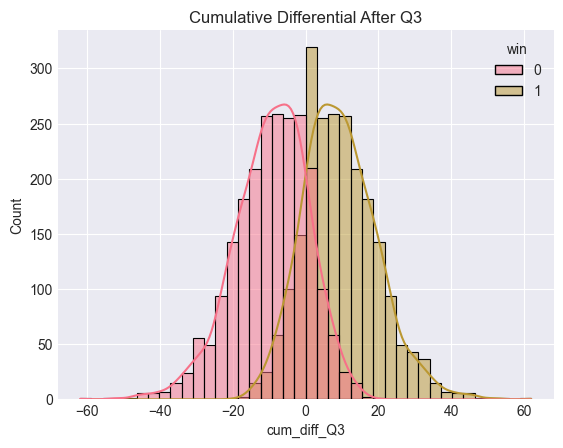

In [85]:
sns.histplot(data=df_full, x='cum_diff_Q3', hue='win', kde=True, bins=40)
plt.title("Cumulative Differential After Q3")
plt.show()